Tujuan Sistem rekomendasi:
- Membantu pengguna menemukan anime mirip dengan anime favorit berdasarkan genre, jenis, sumber cerita, popularitas (CBF).

- Memberikan rekomendasi berdasarkan pola komunitas (CF).

# Library

In [ ]:
# Import Library yang dibutuhkan
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import random
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Load & Data Understanding

In [ ]:
# Import module yang disediakan google colab untuk kebutuhan upload file
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
# Download kaggle dataset and unzip the file
!kaggle datasets download -d vishalmane109/anime-recommendations-database
!unzip anime-recommendations-database

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/vishalmane109/anime-recommendations-database
License(s): CC0-1.0
  0% 0.00/3.53M [00:00<?, ?B/s]
100% 3.53M/3.53M [00:00<00:00, 400MB/s]
Archive:  anime-recommendations-database.zip
  inflating: Anime_data.csv          


In [ ]:
raw_anime = pd.read_csv("/content/Anime_data.csv")
raw_anime.head(3)

,Anime_id,Title,Genre,Synopsis,Type,Producer,Studio,Rating,ScoredBy,Popularity,Members,Episodes,Source,Aired,Link
0,1,Cowboy Bebop,"['Action', 'Adventure', 'Comedy', 'Drama', 'Sc...","In the year 2071, humanity has colonized sever...",TV,['Bandai Visual'],['Sunrise'],8.81,363889.0,39.0,704490.0,26.0,Original,"Apr 3, 1998 to Apr 24, 1999",https://myanimelist.net/anime/1/Cowboy_Bebop
1,5,Cowboy Bebop: Tengoku no Tobira,"['Action', 'Space', 'Drama', 'Mystery', 'Sci-Fi']","Another day, another bounty—such is the life o...",Movie,"['Sunrise', 'Bandai Visual']",['Bones'],8.41,111187.0,475.0,179899.0,1.0,Original,"Sep 1, 2001",https://myanimelist.net/anime/5/Cowboy_Bebop__...
2,6,Trigun,"['Action', 'Sci-Fi', 'Adventure', 'Comedy', 'D...","Vash the Stampede is the man with a $$60,000,0...",TV,['Victor Entertainment'],['Madhouse'],8.31,197451.0,158.0,372709.0,26.0,Manga,"Apr 1, 1998 to Sep 30, 1998",https://myanimelist.net/anime/6/Trigun


In [ ]:
# Melihat Jumah baris dan variabel
raw_anime.shape

(17002, 15)

In [ ]:
# Melihat nama-nama kolom dan nilai uniknya sebanyak 5
for col in raw_anime.columns:
    print(f"\nKolom: {col}")
    print(raw_anime[col].unique()[:5])


Kolom: Anime_id
[1 5 6 7 8]

Kolom: Title
['Cowboy Bebop' 'Cowboy Bebop: Tengoku no Tobira' 'Trigun'
 'Witch Hunter Robin' 'Bouken Ou Beet']

Kolom: Genre
["['Action', 'Adventure', 'Comedy', 'Drama', 'Sci-Fi', 'Space']"
 "['Action', 'Space', 'Drama', 'Mystery', 'Sci-Fi']"
 "['Action', 'Sci-Fi', 'Adventure', 'Comedy', 'Drama', 'Shounen']"
 "['Action', 'Magic', 'Police', 'Supernatural', 'Drama', 'Mystery']"
 "['Adventure', 'Fantasy', 'Shounen', 'Supernatural']"]

Kolom: Synopsis
['In the year 2071, humanity has colonized several of the planets and moons of the solar system leaving the now uninhabitable surface of planet Earth behind. The Inter Solar System Police attempts to keep peace in the galaxy, aided in part by outlaw bounty hunters, referred to as "Cowboys." The ragtag team aboard the spaceship Bebop are two such individuals. \r\n  \r\nMellow and carefree Spike Spiegel is balanced by his boisterous, pragmatic partner Jet Black as the pair makes a living chasing bounties and colle

Berikut adalah arti dari setiap kolom secara singkat:

1. **Anime_id**: ID unik untuk setiap anime.
2. **Title**: Judul anime.
3. **Genre**: Daftar genre atau kategori anime (misal: Action, Comedy).
4. **Synopsis**: Ringkasan cerita dari anime.
5. **Type**: Jenis media anime (TV, Movie, OVA, dll).
6. **Producer**: Perusahaan yang memproduksi anime.
7. **Studio**: Studio animasi yang mengerjakan anime.
8. **Rating**: Skor rata-rata dari pengguna (biasanya dari 1–10).
9. **ScoredBy**: Jumlah pengguna yang memberi rating.
10. **Popularity**: Peringkat popularitas berdasarkan jumlah anggota dan aktivitas pengguna.
11. **Members**: Jumlah pengguna yang menambahkan anime ke daftar mereka (watching, completed, dll).
12. **Episodes**: Jumlah episode anime.
13. **Source**: Sumber cerita anime (Original, Manga, Game, dll).
14. **Aired**: Tanggal tayang atau rilis anime.
15. **Link**: Tautan ke halaman anime di MyAnimeList.

In [ ]:
# Meliha tipe data
raw_anime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17002 entries, 0 to 17001
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Anime_id    17002 non-null  int64  
 1   Title       17002 non-null  object 
 2   Genre       14990 non-null  object 
 3   Synopsis    15583 non-null  object 
 4   Type        16368 non-null  object 
 5   Producer    7635 non-null   object 
 6   Studio      7919 non-null   object 
 7   Rating      14425 non-null  float64
 8   ScoredBy    13227 non-null  float64
 9   Popularity  16368 non-null  float64
 10  Members     17002 non-null  float64
 11  Episodes    14085 non-null  float64
 12  Source      15075 non-null  object 
 13  Aired       16368 non-null  object 
 14  Link        16368 non-null  object 
dtypes: float64(5), int64(1), object(9)
memory usage: 1.9+ MB


Dalam data tersebut terdapat 6 variabel yang bertipe data numerik dan 9 adalah object atau kategorikal

In [ ]:
# Cek Missing Value
raw_anime.isnull().sum()

,0
Anime_id,0
Title,0
Genre,2012
Synopsis,1419
Type,634
Producer,9367
Studio,9083
Rating,2577
ScoredBy,3775
Popularity,634


Setelah mengecek missing value:
- Hanya Variabel Anime_id, Title, dan Members yang tidak punya missing value
- Variabel Producer dan Studio mempunyai missing value yang melebihi setengahnya dari total keseluruhan data

In [ ]:
# Cek duplikasi data
raw_anime.duplicated().sum()

np.int64(63)

dataset tidak mempunyai data yang duplikat

# Data Preparation

Membuat dataframe baru dengan kolom-kolom utama yang akan digunakan sebagai fitur pada sistem rekomendasi anime.

In [ ]:
selected_columns = ['Title', 'Genre', 'Type', 'Rating', 'Popularity', 'Members', 'Source']
data_anime  = raw_anime[selected_columns].copy()
print(data_anime .head())

                             Title  \
0                     Cowboy Bebop   
1  Cowboy Bebop: Tengoku no Tobira   
2                           Trigun   
3               Witch Hunter Robin   
4                   Bouken Ou Beet   

                                               Genre   Type  Rating  \
0  ['Action', 'Adventure', 'Comedy', 'Drama', 'Sc...     TV    8.81   
1  ['Action', 'Space', 'Drama', 'Mystery', 'Sci-Fi']  Movie    8.41   
2  ['Action', 'Sci-Fi', 'Adventure', 'Comedy', 'D...     TV    8.31   
3  ['Action', 'Magic', 'Police', 'Supernatural', ...     TV    7.34   
4  ['Adventure', 'Fantasy', 'Shounen', 'Supernatu...     TV    7.04   

   Popularity   Members    Source  
0        39.0  704490.0  Original  
1       475.0  179899.0  Original  
2       158.0  372709.0     Manga  
3      1278.0   74889.0  Original  
4      3968.0   11247.0     Manga  


In [ ]:
# Cek missing value
data_anime.isnull().sum()

,0
Title,0
Genre,2012
Type,634
Rating,2577
Popularity,634
Members,0
Source,1927


Missing value pada kolom kategorikal seperti Genre, Type, dan Source diisi dengan 'Unknown' agar tetap bisa digunakan dalam perbandingan antar item. Sementara itu, missing value pada kolom numerik Rating dan Popularity diisi dengan nilai median karena lebih tahan terhadap outlier dan menjaga distribusi data tetap stabil.

In [ ]:
# Isi missing value pada kolom kategorikal dengan 'Unknown'
data_anime['Genre'] = data_anime['Genre'].fillna('Unknown')
data_anime['Type'] = data_anime['Type'].fillna('Unknown')
data_anime['Source'] = data_anime['Source'].fillna('Unknown')
# Isi missing value pada kolom numerik (Rating) dengan median
data_anime['Rating'] = data_anime['Rating'].fillna(data_anime['Rating'].median())
data_anime['Popularity'] = data_anime['Popularity'].fillna(data_anime['Popularity'].median())

In [ ]:
# Cek duplikat
data_anime.duplicated().sum()

np.int64(78)

data_anime memlki duplikat sebanyak 78. Maka akan dilakukan penghapusan duplikat lalu reset index

In [ ]:
# Hapus duplikat
data_anime = data_anime.drop_duplicates()
# reset index
data_anime = data_anime.reset_index(drop=True)

In [ ]:
# Cek kategori dalam Type yang unik
data_anime.Type.unique()

array(['TV', 'Movie', 'OVA', 'Special', 'ONA', 'Music', 'Unknown'],
      dtype=object)

In [ ]:
# Cek kategori dalam Source yang unik
data_anime.Source.unique()

array(['Original', 'Manga', 'Light novel', 'Game', 'Visual novel',
       '4-koma manga', 'Novel', 'Unknown', 'Other', 'Picture book',
       'Web manga', 'Music', 'Book', 'Card game', 'Radio',
       'Digital manga'], dtype=object)

"Nilai 'Other' digabung ke 'Unknown' karena keduanya menunjukkan sumber cerita yang tidak spesifik atau tidak diketahui secara jelas."

Ini dilakukan untuk menyederhanakan kategori dan mengurangi ambiguitas saat pemodelan, terutama karena keduanya tidak memberikan informasi eksplisit tentang asal cerita anime.

In [ ]:
data_anime['Source'] = data_anime['Source'].replace('Other', 'Unknown')

Variabel Genre berbentuk string maka akan diubah menjadi list

In [ ]:
data_anime['Genre'] = data_anime['Genre'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) and x.startswith('[') else [])
print(data_anime['Genre'].head())

0    [Action, Adventure, Comedy, Drama, Sci-Fi, Space]
1              [Action, Space, Drama, Mystery, Sci-Fi]
2    [Action, Sci-Fi, Adventure, Comedy, Drama, Sho...
3    [Action, Magic, Police, Supernatural, Drama, M...
4          [Adventure, Fantasy, Shounen, Supernatural]
Name: Genre, dtype: object


Variabel Genre memiliki nilai Unknown, agar tidak menjadii list kosong maka nilai unknown akan tetap disimpan

In [ ]:
data_anime['Genre'] = data_anime['Genre'].apply(lambda x: ['Unknown'] if not x else x)

Terlihat bahwa nilai unique genre ada yg dipisahkan degan spasi dan tanda strip. Untuk menghindari gangguan pada analisis berikutnya spasi dan tanda strip akan diganti menjadi underscore

In [ ]:
def preprocess_genre(genre):
    # Ganti spasi dan strip jadi underscore
    genre = genre.replace(' ', '_').replace('-', '_').lower()
    return genre

def preprocess_genres(genres_list):
    return ' '.join(preprocess_genre(g) for g in genres_list)

# apply
data_anime['Genre'] = data_anime['Genre'].apply(preprocess_genres)
print(data_anime['Genre'].head())

0        action adventure comedy drama sci_fi space
1                 action space drama mystery sci_fi
2      action sci_fi adventure comedy drama shounen
3    action magic police supernatural drama mystery
4            adventure fantasy shounen supernatural
Name: Genre, dtype: object


Setelah itu, akan menggabungkan variabel Type dan Source supaya fitur jadi lebih spesifik dan ngasih konteks lengkap tentang format dan asal cerita anime, misalnya TV_Original beda sama Movie_Manga

In [ ]:
# Gabung kolom Type dan Source jadi satu kolom baru
data_anime['Type_Source'] = data_anime['Type'] + '_' + data_anime['Source']
# Hapus kolom Type dan Source asli setelah diproses
data_anime = data_anime.drop(columns=['Type', 'Source'])

### Data Preparation Untuk Collaborative Filtering (CF)

Dilakukan tambahan tahap persiapan data untuk metode collaborative filtering (CF). Metode CF berfokus pada pola interaksi pengguna terhadap anime, sehingga memerlukan data dalam bentuk relasi antara pengguna dan item (anime).

In [ ]:
# Copy data untuk proses cf
anime_cf = data_anime.copy()
anime_cf.shape

(16924, 6)

Dengan menggunakan metode Collaborative Filtering (CF) perlu interaksi pengguna terhadap item. Maka, Penambahan kolom user_id dilakukan karena metode Collaborative Filtering (CF) membutuhkan struktur data berbentuk interaksi antara pengguna dan item. Karena dataset yang digunakan hanya berisi informasi tentang anime tanpa mencantumkan siapa yang memberikan penilaian, maka dibuatlah kolom user_id secara mandiri

In [ ]:
# Tambahkan user_id dari 00001 sampai 16924
anime_cf['user_id'] = [f"{i:05d}" for i in range(1, len(anime_cf) + 1)]

**Encode variabel user_id dan title**

In [ ]:
# Mengubh user_id dan Title jadi List
user_ids = anime_cf['user_id'].unique().tolist()
anime_titles = anime_cf['Title'].unique().tolist()
# encode user_id dan Title
user_to_encoded = {x: i for i, x in enumerate(user_ids)}
anime_to_encoded = {x: i for i, x in enumerate(anime_titles)}
# Melakukan proses encoding angka ke ke user_id dan Title
encoded_to_user = {i: x for i, x in enumerate(user_ids)}
encoded_to_anime = {i: x for i, x in enumerate(anime_titles)}
# Tambahkan kolom encoded ke DataFrame
anime_cf['identity_user'] = anime_cf['user_id'].map(user_to_encoded)
anime_cf['anime_title'] = anime_cf['Title'].map(anime_to_encoded)

**Mengubah rating ke float**

In [ ]:
# Ubah rating ke float
anime_cf['Rating'] = anime_cf['Rating'].values.astype(np.float32)

In [ ]:
#  Hitung jumlah user dan anime
num_users = len(user_to_encoded)
num_anime = len(anime_to_encoded)
#  Cek rating range
min_rating = anime_cf['Rating'].min()
max_rating = anime_cf['Rating'].max()
print(f'Number of Users: {num_users}')
print(f'Number of Anime: {num_anime}')
print(f'Min Rating: {min_rating}, Max Rating: {max_rating}')

Number of Users: 16924
Number of Anime: 16737
Min Rating: 1.0, Max Rating: 10.0


**Split data (80:20)**

In [ ]:
# Mengacak dataset
anime_cf = anime_cf.sample(frac=1, random_state=42)
# Membuat variabel input x
x = anime_cf[['identity_user', 'anime_title']].values
# Membuat Variabel targe y dan normalisasi
y = anime_cf['Rating'].apply(lambda r: (r - min_rating) / (max_rating - min_rating)).values
# Membagi data train dan validasi
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

# Modeling  1 : Content Based Filtering (CBF)

In [ ]:
# Copy data untuk CBF
anime_cbf = data_anime.copy()

### TF-IDF

In [ ]:
# Buat vectorizer untuk Genre
tf_genre = TfidfVectorizer()
tf_genre.fit(data_anime['Genre'])
genre_features = tf_genre.get_feature_names_out()

# Buat vectorizer untuk Type_Source
tf_type_source = TfidfVectorizer()
tf_type_source.fit(data_anime['Type_Source'])
type_source_features = tf_type_source.get_feature_names_out()

In [ ]:
# Melakukan fit lalu ditransformasikan ke bentuk matrix
tfidf_matrix_genre = tf_genre.transform(data_anime['Genre'])
tfidf_matrix_type_source = tf_type_source.transform(data_anime['Type_Source'])
# Mengubah vektor tf-idf dalam bentuk matriks dengan fungsi todense()
dense_genre = tfidf_matrix_genre.todense()
dense_type_source = tfidf_matrix_type_source.todense()

In [ ]:
# hasil matrrix Genre terhadap title
df_tfidf_genre = pd.DataFrame(
    dense_genre,
    columns=tf_genre.get_feature_names_out(),
    index=data_anime['Title']
)
df_tfidf_genre.sample(10, axis=0).sample(15, axis=1)

,shounen_ai,demons,yaoi,thriller,sci_fi,josei,mecha,slice_of_life,music,supernatural,sports,adventure,super_power,samurai,martial_arts
Title,,,,,,,,,,,,,,,
Hataraku Saibou Specials,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
Xiong Chumo Zhi: Guonian,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.613898,0.0,0.0,0.0
Onegai☆Teacher: Himitsu na Futari,0.0,0.0,0.0,0.0,0.465460,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
Zumomo to Nupepe,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
Nougyou Musume!,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
Oh Baby Plus,0.0,0.0,0.0,0.0,0.676192,0.0,0.0,0.0,0.736725,0.0,0.0,0.000000,0.0,0.0,0.0
Dr. Slump Movie 04: Arale-chan Hoyoyo! Nanaba Shiro no Hihou,0.0,0.0,0.0,0.0,0.607179,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
Piercing I,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
Trip Trek,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.634099,0.0,0.0,0.0


Nilai TF-IDF itu nunjukin seberapa penting sebuah genre buat anime itu dibandingin anime lain. Kalau nilainya deket 1, berarti genre itu emang bener-bener khas buat anime itu. Kalau 0 berarti gak ada genre itu di anime tersebut. Misal, di anime Hana no Zundamaru: Junk genre parody nilainya 0,64, itu artinya genre parody cukup kuat di anime ini, tapi genre comedy cuma 0,31 yang artinya kurang dominan. Sedangkan di Cynical Hysterie Hour: Utakata no Uta, genre comedy nilainya 1, jadi comedy bener-bener genre utama buat anime ini, dan genre lain nilainya 0 alias gak ada.

### Cosine Similarity

Karena pakai dua fitur berbeda (genre & type_source) maka bisa gabungkan hasil similarity-nya

In [ ]:
# cosine similarity genre
cosine_sim_genre = cosine_similarity(tfidf_matrix_genre)
# cosine similarity type_source
cosine_sim_type_source = cosine_similarity(tfidf_matrix_type_source)
# kombinasi
cosine_sim_combined = (cosine_sim_genre + cosine_sim_type_source) / 2

Buat dataframe agar melihat nilai similarity antar anime berdasaarkan title

In [ ]:
cosine_sim_df = pd.DataFrame(cosine_sim_combined, index=data_anime['Title'], columns=data_anime['Title'])
# Melihat similarity matrix pada setiap resto
cosine_sim_df.sample(5, axis=1).sample(10, axis=0)

Title,Aniyome wa Ijippari,Gin no Guardian,Mudai,One Piece: Glorious Island,Xia Gan Yi Dan Shen Jianxin
Title,,,,,
Tobidase!! Buddy-kun,0.0,0.000000,0.000000,0.000000,0.000000
Internal Medicine,1.0,0.000000,0.000000,0.000000,0.000000
Bishoujo Senshi Sailor Moon: Sailor Stars,0.0,0.234827,0.179949,0.159793,0.100160
Mobile Suit Gundam Unicorn RE:0096,0.0,0.000000,0.075919,0.049493,0.049359
Anime Tenchou x Touhou Project,0.0,0.204255,0.000000,0.107518,0.000000
Kobo-chan no Koutsuu Anzen,0.0,0.135242,0.000000,0.000000,0.000000
Naita Aka Oni (OVA),0.0,0.000000,0.108248,0.000000,0.000000
Tengoku,0.0,0.000000,0.254558,0.000000,0.000000
Pokemon XY: Hoopa no Odemashi Daisakusen!!,0.0,0.207454,0.000000,0.175764,0.066381


Nilai similarity itu nunjukin seberapa mirip dua anime berdasarkan genre dan tipe sumbernya. Nilai 0 artinya sama sekali beda, 1 artinya sama banget. Misalnya, anime Oh! My Konbu sama Sore Ike! Anpanman: Kokin-chan to Namida no Christmas nilainya 0.098, itu artinya mereka hampir gak mirip, genre dan tipe sumbernya beda jauh.

Kalau Doraemon Movie 27: Nobita no Shin Makai Daibouken - 7-nin no Mahoutsukai sama Doujouji nilainya 0.5, artinya mereka punya kemiripan sedang, mungkin ada beberapa genre atau tipe sumber yang sama.

Jadi, makin besar nilainya, makin mirip animenya, dan makin besar kemungkinan direkomendasiin bareng.

### Membuat Fungsi untuk prediksi "Sistem Rekomendasi"

In [ ]:
from difflib import get_close_matches
def anime_recommendations(name_anime, similarity_data=cosine_sim_df, items=data_anime[['Title', 'Genre', 'Type_Source']], k=5):
  # Cek apakah judul ada di kolom similarity_data
    if name_anime not in similarity_data.columns:
        # Cari judul paling mirip
        possible_titles = get_close_matches(name_anime, similarity_data.columns, n=1, cutoff=0.6)
        if not possible_titles:
            return f"Tidak ditemukan judul mirip untuk: {name_anime}"
        name_anime = possible_titles[0]
        print(f"Judul tidak ditemukan persis, pakai judul terdekat: {name_anime}")
    # Ambil nilai similarity dari anime yang dicari
    similarity_scores = similarity_data[name_anime]

    # Urutkan dari yang paling mirip, buang dirinya sendiri
    closest = similarity_scores.sort_values(ascending=False).drop(name_anime).head(k)

    # Buat dataframe rekomendasi
    closest_df = pd.DataFrame({'Title': closest.index})
    rekomendasi = closest_df.merge(items, on='Title')
    rekomendasi['Similarity'] = closest.values  # Tambahkan skor kemiripan

    return rekomendasi


In [ ]:
hasil = anime_recommendations('Naruto', k=5)
hasil

,Title,Genre,Type_Source,Similarity
0,Naruto: Shippuuden,action adventure comedy super_power martial_ar...,TV_Manga,1.000000
1,Boruto: Naruto Next Generations,action adventure martial_arts shounen super_power,TV_Manga,0.983896
2,Rekka no Honoo,action adventure martial_arts shounen super_power,TV_Manga,0.983896
3,Dragon Ball Kai (2014),action adventure comedy fantasy martial_arts s...,TV_Manga,0.975871
4,Dragon Ball Kai,action adventure comedy fantasy martial_arts s...,TV_Manga,0.975871


In [ ]:
result = anime_recommendations('Dragon Ball Kai', k=5)
result

,Title,Genre,Type_Source,Similarity
0,Dragon Ball Kai (2014),action adventure comedy fantasy martial_arts s...,TV_Manga,1.000000
1,Dragon Ball Super,action adventure comedy fantasy martial_arts s...,TV_Manga,1.000000
2,Dragon Ball,adventure comedy fantasy martial_arts shounen ...,TV_Manga,0.978727
3,Naruto: Shippuuden,action adventure comedy super_power martial_ar...,TV_Manga,0.975871
4,Naruto,action adventure comedy super_power martial_ar...,TV_Manga,0.975871


In [ ]:
#akkan error
#result = anime_recommendations('Shingeki no Kyojin', k=5)
#result

TypeError: DataFrame.sort_values() missing 1 required positional argument: 'by'

### Evaluasi CBF

# Modeling 2 : Collaborative Filtering (CF)

### Training

Membangun arsitektur model

In [ ]:
class RecommenderNet(tf.keras.Model):
    def __init__(self, num_users, num_anime, embedding_size=128, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)

        self.user_embedding = layers.Embedding(
            input_dim=num_users,
            output_dim=embedding_size,
            embeddings_initializer='he_normal',
            embeddings_regularizer=keras.regularizers.l2(1e-6)
        )
        self.user_bias = layers.Embedding(num_users, 1)

        self.anime_embedding = layers.Embedding(
            input_dim=num_anime,
            output_dim=embedding_size,
            embeddings_initializer='he_normal',
            embeddings_regularizer=keras.regularizers.l2(1e-6)
        )
        self.anime_bias = layers.Embedding(num_anime, 1)

        # Penambahan hidden layers
        self.dense1 = layers.Dense(128, activation='relu')
        self.dense2 = layers.Dense(64, activation='relu')
        self.dense3 = layers.Dense(64, activation='relu')
        self.output_layer = layers.Dense(1, activation='sigmoid')

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        anime_vector = self.anime_embedding(inputs[:, 1])
        anime_bias = self.anime_bias(inputs[:, 1])

        dot_user_anime = tf.reduce_sum(user_vector * anime_vector, axis=1, keepdims=True)
        x = dot_user_anime + user_bias + anime_bias
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense3(x)
        return self.output_layer(x)


Melatih Model

In [ ]:
embedding_size = 50
model = RecommenderNet(num_users, num_anime, embedding_size) # inisialisasi model

# model compile
model.compile(
    loss='mae',
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

In [ ]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=50,
    verbose=1,
    validation_data=(x_val, y_val)
)

Epoch 1/50
212/212 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - loss: 0.0899 - root_mean_squared_error: 0.1205 - val_loss: 0.0852 - val_root_mean_squared_error: 0.1208
Epoch 2/50
212/212 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - loss: 0.0820 - root_mean_squared_error: 0.1152 - val_loss: 0.0886 - val_root_mean_squared_error: 0.1219
Epoch 3/50
212/212 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - loss: 0.0677 - root_mean_squared_error: 0.0973 - val_loss: 0.0958 - val_root_mean_squared_error: 0.1276
Epoch 4/50
212/212 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - loss: 0.0589 - root_mean_squared_error: 0.0841 - val_loss: 0.1011 - val_root_mean_squared_error: 0.1297
Epoch 5/50
212/212 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - loss: 0.0567 - root_mean_squared_error: 0.0803 - val_loss: 0.0999 - val_root_mean_squared_error: 0.1291
Epoch 6/50
212/212 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - loss: 0.0492 - root_mean_squared_error: 0.0745 - val_loss: 0.1024 - val_root_mean_squared_error: 0.1316
Epoch 7/50
212/212 ━━━━━━━━━━━━━━━━━━━━ 8s 

### Sistem Rekomendas CF

In [ ]:
import random
# Pilih user_id secara acak dari daftar user yang tersedia
sample_user_id = random.choice(anime_cf['user_id'].unique())
# Anime yang sudah ditonton user
watched_anime = anime_cf[anime_cf.user_id == sample_user_id]['Title'].values

# Ambil anime yang belum ditonton
not_watched = anime_cf[~anime_cf['Title'].isin(watched_anime)]['Title'].unique()

# Filter hanya anime yang ada dalam encoded mapping
not_watched = list(set(not_watched).intersection(set(anime_to_encoded.keys())))

# Encode anime yang belum ditonton
not_watched_encoded = [[anime_to_encoded[x]] for x in not_watched]
# Encode user_id ke bentuk numerik (identity_user) agar cocok untuk model
user_encoded = user_to_encoded[sample_user_id]

In [ ]:
# Buat array prediksi
user_anime_array = np.hstack(
    ([[user_encoded]] * len(not_watched_encoded), not_watched_encoded)
)

# Prediksi skor
ratings = model.predict(user_anime_array).flatten()

# Urutkan dari skor tertinggi
top_indices = ratings.argsort()[::-1]
# Ambil anime yang direkomendasikan (top 10)
top_anime_encoded = [not_watched_encoded[i][0] for i in top_indices[:10]]
recommended_titles = [encoded_to_anime[x] for x in top_anime_encoded]
predicted_ratings = [ratings[i] for i in top_indices[:10]]

# Ambil data tambahan (rating, popularity, members)
rekomendasi_df = pd.DataFrame({
    'Title': recommended_titles,
    'Predicted_Rating': predicted_ratings
})

# Gabungkan dengan info dari anime_cf (drop duplikat biar merge akurat)
anime_info = anime_cf.drop_duplicates(subset='Title')[['Title', 'Rating', 'Popularity',  "Genre",'Members']]
rekomendasi_df = rekomendasi_df.merge(anime_info, on='Title', how='left')

# Tampilkan
print(f"\n Rekomendasi anime untuk user {sample_user_id}:\n")
for i, row in rekomendasi_df.iterrows():
    print(f"{i+1}. {row['Title']}")
    print(f"   Predicted Rating: {row['Predicted_Rating']:.2f}")
    print(f"   Original Rating: {row['Rating']}")
    print(f"   Popularity: {int(row['Popularity'])}")
    print(f"   Genre: {row['Genre']}")
    print(f"   Members: {int(row['Members']) if not pd.isna(row['Members']) else 0}")
    print()

523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

 Rekomendasi anime untuk user 11531:

1. Xiao Hua Xian
   Predicted Rating: 0.72
   Original Rating: 10.0
   Popularity: 15060
   Genre: kids magic
   Members: 11

2. Kuunyan no Koutsuu Anzen: Tadashii Jitensha no Nori Kata
   Predicted Rating: 0.70
   Original Rating: 10.0
   Popularity: 15908
   Genre: kids
   Members: 32

3. Manichi ga Tsurai Kimochi Wakarimasu ka: Yurusenai! Net Ijime
   Predicted Rating: 0.68
   Original Rating: 10.0
   Popularity: 15968
   Genre: kids
   Members: 29

4. Tat-chan - Momo-chan no Fushigina Taiken
   Predicted Rating: 0.67
   Original Rating: 9.5
   Popularity: 8115
   Genre: kids drama
   Members: 33

5. Gintama°
   Predicted Rating: 0.65
   Original Rating: 9.149999618530273
   Popularity: 351
   Genre: action comedy historical parody samurai sci_fi shounen
   Members: 197771

6. Steins;Gate
   Predicted Rating: 0.65
   Original Rating: 9.140000343322754
   Popularity: 7
   Genre: thriller sci_fi
   Members

# EVALUASI

### a. precision@k untuk CBF

In [ ]:
def precision_at_k(name_anime, k=5):
    # Dapatkan genre anime target
    target_genre = data_anime.loc[data_anime['Title'] == name_anime, 'Genre'].values[0]

    # Dapatkan rekomendasi anime (misal pakai fungsi yang sudah ada)
    rekomendasi = anime_recommendations(name_anime, k=k)

    # Hitung berapa yang genre-nya sama dengan target
    relevan = rekomendasi['Genre'].apply(lambda x: target_genre in x)

    # Precision@k = jumlah relevan / k
    precision = relevan.sum() / k

    return precision

In [ ]:
hasil_precision = precision_at_k('Naruto', k=5)
print(f"Precision@5 untuk Naruto: {hasil_precision:.2f}")

Precision@5 untuk Naruto: 0.20


Sebagai contoh, nilai Precision@5 untuk anime "Naruto" adalah 0.20. Artinya, dari 5 rekomendasi teratas yang diberikan, hanya sekitar 20% (1 dari 5) yang memiliki genre yang sama dengan "Naruto". Hasil ini menunjukkan bahwa akurasi rekomendasi berdasarkan genre masih dapat ditingkatkan agar lebih relevan dengan preferensi pengguna.

B. Loss Curve untuk CF

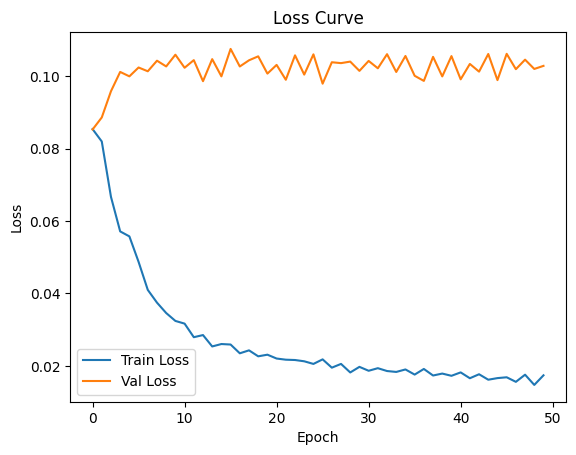

In [ ]:

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title("Loss Curve")
plt.show()

Berdasarkan Kurva Loss:

- Train Loss menurun dan stabil di angka rendah seiring bertambahnya epoch.
- Val Loss Setelah beberapa epoch awal, tidak menurun, justru tetap tinggi dan cenderung stagnan bahkan sedikit naik dengan fluktuasi.
- Gap besar antara train loss dan val loss dan Val loss tidak membaik
- Maka, Model mengalami Overfitting